In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from gumbel_V3_NS_shGLM import gumbel_NS_shGLM
from sklearn import metrics
import torch.distributions as dist

# Hyperparams

In [2]:
train_T = 40000
test_T = 8000
T_syn = 75
T_hist = 75
C_den = torch.zeros(5,5)
C_den[0,1:] = 1
#C_den = torch.zeros(1).reshape(1,1)
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 2
hist_basis_no = 2
prop_basis_no = 2


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([0+106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:48000]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([8000])


In [5]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [6]:
repeat_no = 4
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

154000
154000


In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.002)
#optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


1521


In [8]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred, _, __ = model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
        
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    #loss_array[i] = loss.item()
        
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred, _,__ = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        #print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        #if i%100 == 0:
            #torch.save(model.state_dict(), "/media/hdd01/sklee/cont_shglm/burst_L23_NS_sub5_s2_h2_shglm_i"+str(i)+".pt")
            #loss_array[i//100,0] = i
            #loss_array[i//100,1] = test_score
            #np.save("/media/hdd01/sklee/cont_shglm/burst_L23_NS_test_scores.npy", loss_array)


<ipython-input-8-32b6a56f981f>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 120.07669078786996 -0.5078387711679959 -1.2381121680454017
TEST 50 47.52779536585948 0.40317931866977785 0.35839329002231346
TEST 100 39.31417211669169 0.5063202320734048 0.4186146391532952
TEST 150 35.306482708128826 0.5566459815782671 0.5423614745779742
TEST 200 34.8719320782827 0.562102763264374 0.5004392390786343
TEST 250 34.45045076157721 0.5673954296980132 0.7019611404275836
TEST 300 33.6585095758378 0.5773400710054255 0.5524765223675138
TEST 350 34.50396089780025 0.5667234869800494 0.6606976485673959
TEST 400 33.81156015263765 0.5754181693500381 0.5750378689768447
TEST 450 34.08617960431444 0.5719696910881733 0.5706984446060428
TEST 500 34.02518749145096 0.5727355872256534 0.5668470273045773



KeyboardInterrupt: 

In [9]:
print(model.conv_e.weight.shape)

torch.Size([5, 1, 75])


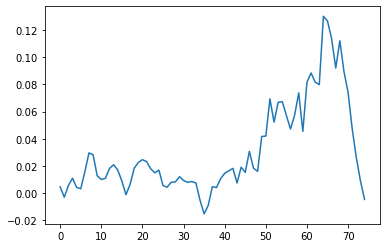

In [10]:
plt.plot(model.conv_e.weight[1,0,:].cpu().detach().numpy())

# Test 

In [5]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/burst_L23_NS_sub5_s2_h2_shglm_i9900.pt"))
model = model.float().to("cuda")

V_ref = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:48000]

test_V_ref = V_ref[train_T:train_T+test_T]


In [6]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")

test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final, raw1, raw2 = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()
raw1 = raw1.cpu().detach().numpy()
raw2 = raw2.cpu().detach().numpy()

0.8148457582803112


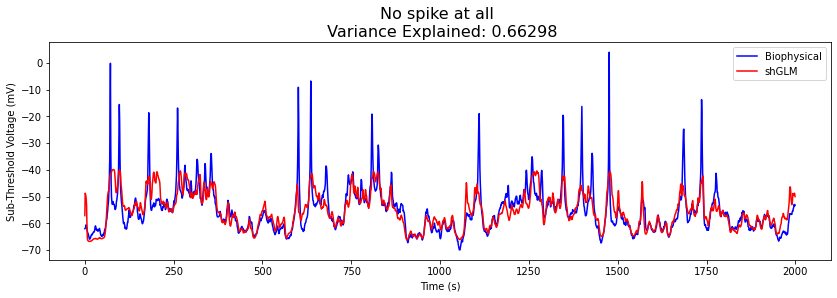

In [7]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:2000], label="Biophysical", c="blue")
plt.plot(test_V_final[:2000]-23,label="shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("No spike at all \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/cont_shglm/non_spike.png", dpi=150, bbox_inches='tight')#

In [20]:
output_save = np.vstack((test_V_ref.reshape((1,-1)), test_V_final.reshape((1,-1))))
print(output_save.shape)
dend_save = np.vstack((raw1.T.reshape((1,4,8000)), raw2.T.reshape((1,4,8000))))
print(dend_save.shape)

np.save("/media/hdd01/sklee/cont_shglm/gumbelNS_test_V.npy", output_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelNS_test_dend.npy", dend_save)

(2, 8000)
(2, 4, 8000)


(2, 4, 8000)


In [7]:
for name, param in model.named_parameters():
    print(name, param.data)

W_s_syn tensor([[[-0.1624, -0.0848],
         [ 0.1365,  0.0448]],

        [[ 0.3157, -0.0853],
         [ 0.1495, -0.3303]],

        [[ 0.1255, -0.0034],
         [ 0.1035, -0.0407]],

        [[ 0.3448, -0.0469],
         [ 0.0828, -0.1274]],

        [[-0.0161,  0.1923],
         [ 0.1236, -0.1168]]], device='cuda:0')
W_ns_syn tensor([[[ 0.2483, -0.0441],
         [ 0.0923, -0.0547]],

        [[ 0.1721, -0.1139],
         [ 0.2915, -0.2533]],

        [[ 0.1550, -0.1090],
         [ 0.1909, -0.2760]],

        [[ 0.0469, -0.0140],
         [ 0.1290, -0.2260]],

        [[ 0.2104, -0.1224],
         [ 0.2423, -0.3467]]], device='cuda:0')
Tau_s_syn tensor([[-0.1319, -0.2743],
        [ 3.1384,  3.2318]], device='cuda:0')
Tau_ns_syn tensor([[-0.1486, -0.8959],
        [ 1.7912,  1.2792]], device='cuda:0')
Delta_s_syn tensor([[0.1235, 0.8714],
        [3.1644, 2.6106],
        [0.0321, 3.5678],
        [0.5318, 3.0040],
        [2.5279, 1.5562]], device='cuda:0')
Delta_ns_syn tensor(